In [49]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [77]:
total_population_data = pd.read_csv('../preprocess_data/human_2022.csv',  index_col = 'Unnamed: 0')
leavecom = pd.read_excel("../raw_data/내외국인_성_연령별_국제이동_월간__연간__20231129135928.xlsx", index_col='연령별').T.drop(['연령별','계'], axis=1).iloc[2:].mean(axis=0)
mortality_data = pd.read_csv('../preprocess_data/연령별 사망률 추계.csv', index_col = '시점')

/Users/minkyuramen/anaconda3/envs/hoxi_algorithm/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [78]:
sde1 = pd.read_csv('../result/sde.csv',index_col='year')
sde1.index = pd.to_datetime(sde1.index)
sde1.head()

,출생아수
year,
2023-01-01,249137.701438
2024-01-01,249556.137028
2025-01-01,249419.063343
2026-01-01,249370.169024
2027-01-01,248782.531734


<Axes: title={'center': '출생아수 예측'}, xlabel='year'>

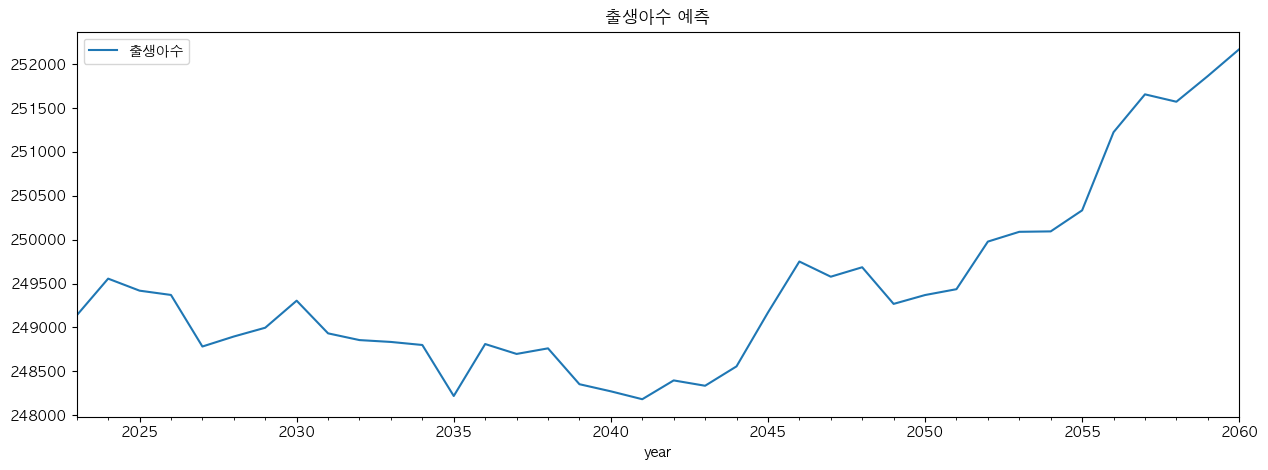

In [79]:
sde1.plot(figsize = (15, 5), title = '출생아수 예측')

In [80]:
def predict_population(target_year, age):  # target_year 예시 : 40, 50
    # 시작 연도 계산
    start_year = target_year - age

    # 사망율 데이터가 시작되는 연도
    mortality_data_start_year = 22

    # 시작 연도가 사망율 데이터 시작 연도보다 이전인 경우
    if start_year <= mortality_data_start_year:
        # 2022년의 총 인구 수로 시작
        age3 = str(22 - age) + '세'
        population = total_population_data.loc[age3, '2022'] # 2022년도의 22-age 살 데이터
        # 2022년부터 대상 연도까지 사망율 적용
        for year in range(mortality_data_start_year, target_year):
            # 연도 형식을 'YYYY-MM-DD'로 맞춤
            year2 = str(year + 2000) + '-01-01'
            age2 = str(year - start_year) + '세 평균'
            survival_rate = 1 - mortality_data.loc[year2][age2]   # mortality_data : 사망율 데이터, mortality_data[연도][나이] 꼴임. 연도는 datetime 꼴이고 나이는 'x세 평균' 꼴임으로 바꿔줌.
            population *= survival_rate
            population += leavecom[age]

    else:
        # 시작 연도의 신생아 수로 시작
        start_year2 = str(start_year + 2000) + '-01-01'
        population = births_data.loc[start_year2, '출생아수']
        # 시작 연도부터 대상 연도까지 사망율 적용
        for year in range(start_year, target_year):
            # 연도 형식을 'YYYY-MM-DD'로 맞춤
            year2 = str(year + 2000) + '-01-01'
            age2 = str(year - start_year) + '세 평균'
            survival_rate = 1 - mortality_data.loc[year2][age2]
            population *= survival_rate

    # 예상 인구 반환
    return population


In [81]:
predict_population(40, 21)

326019.9237386987

In [82]:
predict_population(60, 21)

247932.26642578834

수립한 학령인구 방정식에 근거하여 출생아 수를 기준으로 순차적인 연도의 사망률을 1에서 뺀 값을 곱하고 순이동률을 곱한다.
사망률 추산 데이터가 2022년부터 2070년까지만 있기 때문에 2022년 이전의 사망률을 이용할 수 없다. 따라서 이러한 케이스에서는 2022년의 해당 나이의 총 인구 데이터에서 시작

ex) 2040년도의 20살 학령인구 예측

→ 20년도 신생아 수 x (1 - 20년도 0살 사망률) x (1 - 21년도 1살 사망률) x (1 - 22년도 2살 사망률) x (1 - 23년도 3살 사망률) x … x (1 - 39년도 19살 사망률)

이 경우, 20년도 0살 사망률, 21년도 1살 사망률 데이터가 없기 때문에 2022년 2살 총 인구에서 시작하는 것으로 치환. 즉, 20년도 신생아 수 x (1 - 20년도 0살 사망률) x (1 - 21년도 1살 사망률) → 2022년 2살 총 인구

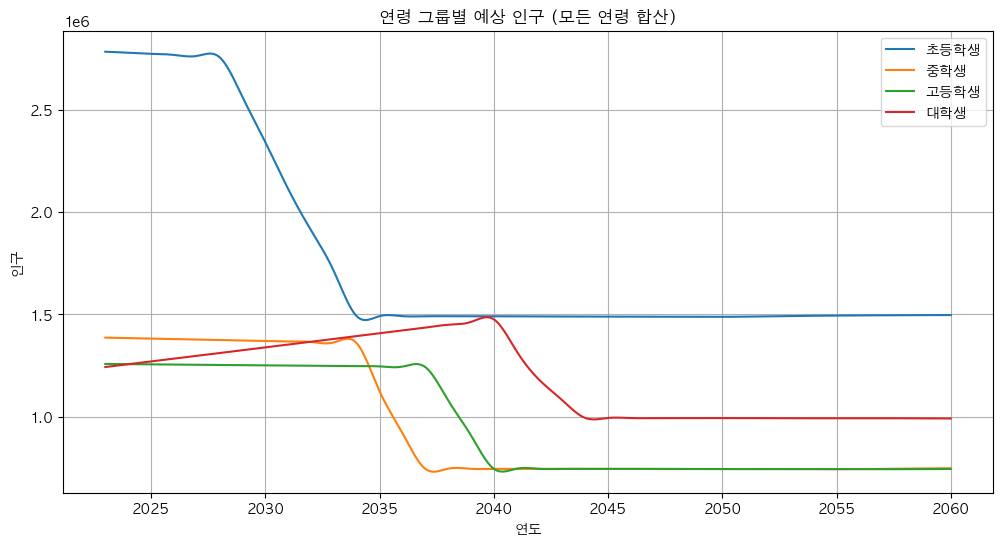

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.font_manager as fm

# 예상 인구를 저장할 딕셔너리
population_data = {
    '대학생': [],
    '고등학생': [],
    '중학생': [],
    '초등학생': []
}

# 대상 연령 그룹 정의
age_groups = {
    '대학생': (18, 21),
    '고등학생': (15, 17),
    '중학생': (12, 14),
    '초등학생': (6, 11)
}

# 대상 연도 범위
start_year = 23
end_year = 60

# 대상 연령 그룹과 연도에 따라 인구 예측
for year in range(start_year, end_year + 1):
    for group, age_range in age_groups.items():
        min_age, max_age = age_range
        # 대상 연령 그룹의 모든 연령에 대한 예상 인구 합산
        total_population = 0
        for age in range(min_age, max_age + 1):
            population = predict_population(year, age)
            total_population += population
            # print(f"Year: {year}, Age: {age}, Predicted Population: {population}")  # Verifying population values
        # 결과를 딕셔너리에 저장
        population_data[group].append(total_population)

# 결과를 데이터프레임으로 변환
df_population = pd.DataFrame(population_data, index=range(start_year + 2000, end_year + 2001))  # Adjust index to actual years
df_population = df_population[['초등학생', '중학생', '고등학생', '대학생']]
# 그래프 그리기
plt.figure(figsize=(12, 6))

# 각 그룹별로 부드러운 곡선 그리기
for group in df_population.columns:
    # Interpolation for smoothing
    x = df_population.index
    y = df_population[group]
    f = interp1d(x, y, kind='cubic')  # 'cubic' spline for smooth curve
    x_new = np.linspace(min(x), max(x), 500)  # Generate new x values for a smooth curve
    y_smooth = f(x_new)

    plt.plot(x_new, y_smooth, label=group)

# 그래프 스타일 및 레이블 설정
plt.title('연령 그룹별 예상 인구 (모든 연령 합산)')
plt.xlabel('연도')
plt.ylabel('인구')
plt.legend()
plt.grid(True)

# 그래프 표시
plt.show()

In [84]:
df_population.index = df_population.index.astype(str)
df_population.index = pd.to_datetime(df_population.index)
df_population

,초등학생,중학생,고등학생,대학생
2023-01-01,2.783912e+06,1.386786e+06,1.258320e+06,1.243183e+06
2024-01-01,2.778753e+06,1.384418e+06,1.257229e+06,1.256772e+06
2025-01-01,2.773579e+06,1.382066e+06,1.256176e+06,1.270405e+06
2026-01-01,2.768394e+06,1.379721e+06,1.255152e+06,1.284073e+06
2027-01-01,2.763190e+06,1.377371e+06,1.254159e+06,1.297775e+06
2028-01-01,2.757066e+06,1.375027e+06,1.253181e+06,1.311516e+06
2029-01-01,2.563504e+06,1.372675e+06,1.252208e+06,1.325282e+06
2030-01-01,2.342519e+06,1.370327e+06,1.251220e+06,1.339077e+06
2031-01-01,2.113777e+06,1.367962e+06,1.250245e+06,1.352891e+06
2032-01-01,1.912239e+06,1.365577e+06,1.249263e+06,1.366714e+06


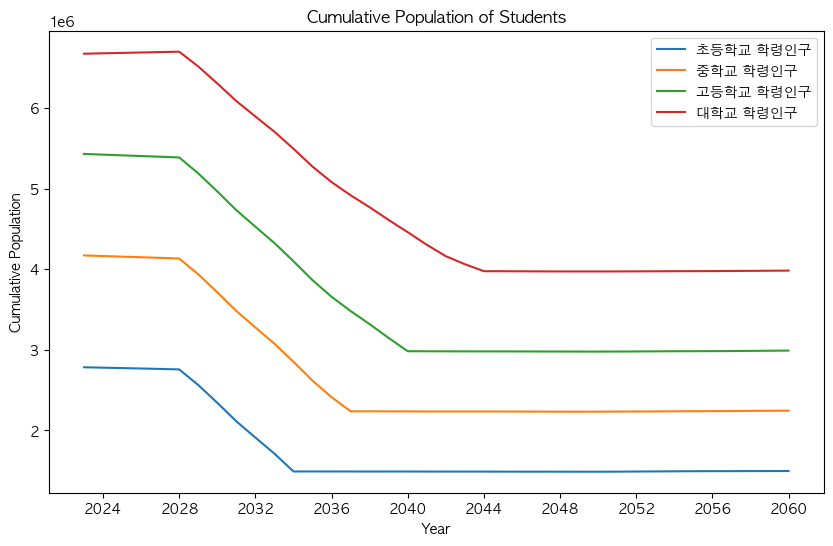

In [85]:
# Calculate cumulative sum

# Plot
plt.figure(figsize=(10,6))
plt.plot(df_population['초등학생'], label='초등학교 학령인구')
plt.plot(df_population['중학생']+df_population['초등학생'], label='중학교 학령인구')
plt.plot(df_population['고등학생']+df_population['초등학생']+df_population['중학생'], label='고등학교 학령인구')
plt.plot(df_population['고등학생']+df_population['초등학생']+df_population['중학생']+df_population['대학생'], label='대학교 학령인구')

# Adding title and labels
plt.title('Cumulative Population of Students')
plt.xlabel('Year')
plt.ylabel('Cumulative Population')
plt.legend()

# Show plot
plt.show()

In [86]:
schools = pd.read_csv("../preprocess_data/학령인구.csv", index_col="Unnamed: 0")
schools.index = pd.to_datetime(schools.index)
schools.columns = ["초등학생", "중학생", "고등학생", "대학생"]
len(schools)
schools = schools.loc[:'2060-01-01']
school = schools.loc[:"2022-01-01"]
school.tail()

,초등학생,중학생,고등학생,대학생
2018-01-01,2756000,1340000,1574000,2593000
2019-01-01,2766000,1319000,1453000,2537000
2020-01-01,2724000,1364000,1390000,2410000
2021-01-01,2718000,1379000,1344000,2258000
2022-01-01,2701000,1366000,1322000,2093000


In [87]:
schools['학령인구'] = schools['초등학생'] + schools['중학생'] + schools['고등학생'] + schools['대학생']
# schools['학령인구']

In [88]:
df_population = df_population[['초등학생', '중학생', '고등학생', '대학생']]
print(len(df_population))
df_population.tail()

38


,초등학생,중학생,고등학생,대학생
2056-01-01,1.495541e+06,744475.696402,743809.076935,992733.664548
2057-01-01,1.495857e+06,745280.610491,743896.951359,992937.153037
2058-01-01,1.496133e+06,746727.304052,744000.086690,992464.880399
2059-01-01,1.496691e+06,747779.345913,744408.699453,992016.625065
2060-01-01,1.497141e+06,748324.907725,745216.036212,991717.642310


In [89]:
school_df = pd.concat([school, df_population], axis=0)

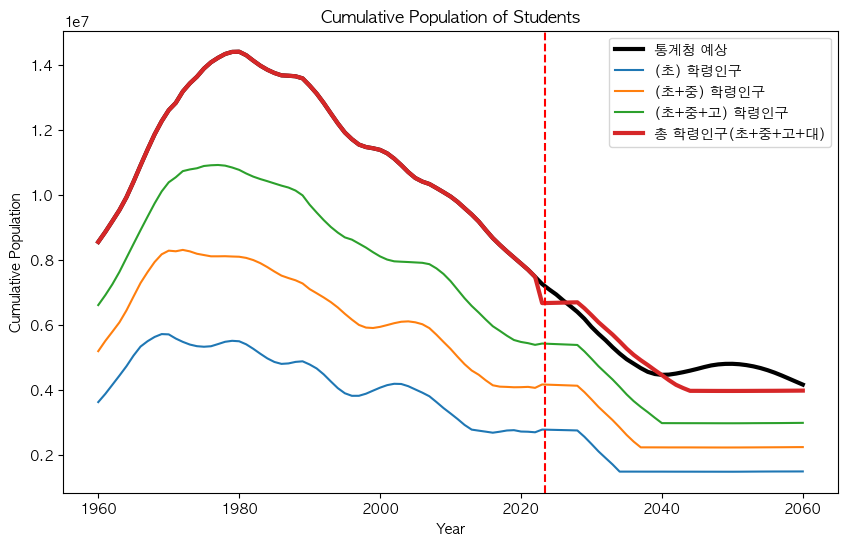

In [90]:
# Calculate cumulative sum
school_df
# Plot
plt.figure(figsize=(10,6))
plt.plot(schools['학령인구'], label='통계청 예상', color='black', lw=3)
plt.plot(school_df['초등학생'], label='(초) 학령인구')
plt.plot(school_df['중학생']+school_df['초등학생'], label='(초+중) 학령인구')
plt.plot(school_df['고등학생']+school_df['초등학생']+school_df['중학생'], label='(초+중+고) 학령인구')
plt.plot(school_df['고등학생']+school_df['초등학생']+school_df['중학생']+school_df['대학생'], label='총 학령인구(초+중+고+대)', lw=3)
plt.axvline(x=19500, color='r', linestyle='--')

# Adding title and labels
plt.title('Cumulative Population of Students')
plt.xlabel('Year')
plt.ylabel('Cumulative Population')
plt.legend()

# Show plot
plt.show()

In [91]:
df_population['학령인구'] = df_population['초등학생'] + df_population['중학생'] + df_population['고등학생'] + df_population['대학생']
df_population['학령인구'] = df_population['학령인구'].astype(int)
df_pred = df_population[['학령인구']].T[['2030-01-01','2040-01-01','2050-01-01','2060-01-01']]
df_pred.index = ['SDE기반 추정 학령인구']

In [92]:
df_pred2 = schools[['학령인구']].T[['2030-01-01','2040-01-01','2050-01-01','2060-01-01']]
df_pred2.index = ['통계청 추정 학령인구']

In [93]:
df_var = pd.concat([df_pred, df_pred2])
df_var

,2030-01-01,2040-01-01,2050-01-01,2060-01-01
SDE기반 추정 학령인구,6303143,4459048,3972056,3982399
통계청 추정 학령인구,5942000,4467000,4806000,4167000
